In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
from pysat.solvers import Solver

## Construct all of the valid pieces

We start with a few basic definitions.

In [2]:
eye3_i64 = np.eye(3).astype(np.int64)
mats = [
    np.array(m, dtype=np.int64).reshape(3, 3)
    for m in itertools.product([-1, 0, 1], repeat=9)
]
SO3 = [
    m for m in mats
    if (m @ m.T == eye3_i64).all() and np.linalg.det(m) == 1
]

def recenter(x: np.ndarray) -> np.ndarray:
    return x - x.min(axis=0)

def are_samey(x: np.ndarray, y: np.ndarray) -> bool:
    return set(map(tuple, recenter(x))) == set(map(tuple, recenter(y)))

def are_alignable(x: np.ndarray, y: np.ndarray) -> bool:
    for a in (x, y):
        assert len(a.shape) == 2
        assert a.shape[1] == 3
    for rot in SO3:
        if are_samey(x, y @ rot):
            return True
    return False

def is_chiral(puzzle_piece: np.ndarray) -> bool:
    return not are_alignable(puzzle_piece, -puzzle_piece)

cardinal_directions = list(eye3_i64) + list(-eye3_i64)

Now we generate all possible shapes that can be made by tacking on one cube at a time to an existing shape, up to four times starting from one cube.

In [3]:
def generate_shapes(so_far, steps):
    if steps == 0:
        yield np.array(so_far)
        return
    for starting_point in so_far:
        for cardinal_direction in cardinal_directions:
            new = starting_point + cardinal_direction
            yield from generate_shapes(so_far + [new], steps-1)

all_shapes = list(generate_shapes([np.array([0, 0, 0], dtype=np.int64)], 4))
len(all_shapes)

31104

However, some of these shapes aren't pentacubes, as they walked over themself multiple times.

In [4]:
all_pentacubes = [
    shape for shape in all_shapes
    if len(set(map(tuple, shape))) == 5
]
len(all_pentacubes)

14928

... and some aren't chiral.

In [5]:
chiral_pentacubes = [
    pc for pc in tqdm(all_pentacubes)
    if is_chiral(pc)
]
len(chiral_pentacubes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14928/14928 [00:02<00:00, 6843.37it/s]


4992

We now expect to have a bunch of copies of each shape, so let's reduce down by equivalence classes.

In [6]:
equiv_classes = []
for pentacube in tqdm(chiral_pentacubes):
    for equiv_class in equiv_classes:
        if are_alignable(pentacube, equiv_class):
            break
    else:
        equiv_classes.append(pentacube)
len(equiv_classes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4992/4992 [00:05<00:00, 872.99it/s]


12

In [7]:
def cube_faces(x, y, z):
    return np.array([
        [[x, y, z], [x+1, y, z], [x+1, y+1, z], [x, y+1, z]],         # bottom face
        [[x, y, z+1], [x+1, y, z+1], [x+1, y+1, z+1], [x, y+1, z+1]], # top face
        [[x, y, z], [x+1, y, z], [x+1, y, z+1], [x, y, z+1]],         # front face
        [[x, y+1, z], [x+1, y+1, z], [x+1, y+1, z+1], [x, y+1, z+1]], # back face
        [[x, y, z], [x, y+1, z], [x, y+1, z+1], [x, y, z+1]],         # left face
        [[x+1, y, z], [x+1, y+1, z], [x+1, y+1, z+1], [x+1, y, z+1]], # right face
    ])

def draw(colors_and_shapes):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    flattened_coords = []
    for color, shape in colors_and_shapes:
        faces = []
        for x, y, z in shape:
            faces.extend(cube_faces(x, y, z))
        ax.add_collection3d(Poly3DCollection(
            faces, facecolors=color, edgecolors='black', linewidths=1, alpha=0.5,
        ))
        flattened_coords.append(shape)
    coords = np.concatenate(flattened_coords)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([np.ptp(coords[:,0])+1, np.ptp(coords[:,1])+1, np.ptp(coords[:,2])+1])
    ax.set_xlim(coords[:,0].min(), coords[:,0].max() + 1)
    ax.set_ylim(coords[:,1].min(), coords[:,1].max() + 1)
    ax.set_zlim(coords[:,2].min(), coords[:,2].max() + 1)
    plt.show()

In [8]:
original_mirror_pairs = []
for cpc in equiv_classes:
    for existing in original_mirror_pairs:
        if len(existing) == 1:
            if are_alignable(existing[0], -cpc):
                existing.append(cpc)
                break
    else:
        original_mirror_pairs.append([cpc])

In [9]:
# We now reorient each pair to be as maximal on the X axis as possible, and minimal on the Z axis.
def optimize(shape):
    def score(s):
        # Spread out along X as much as possible.
        x_extent = s.max(axis=0)[0]
        # Minimize total potential.
        potential = s.sum(axis=0)[2]
        return 1000 * x_extent - potential
    options = [recenter(shape @ r) for r in SO3]
    return max(options, key=score)

Pair:


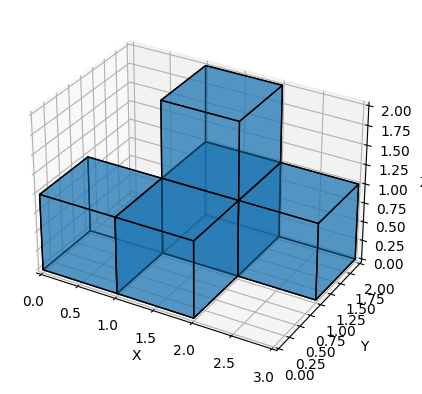

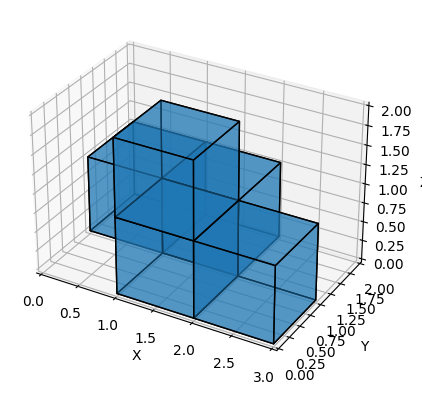

Pair:


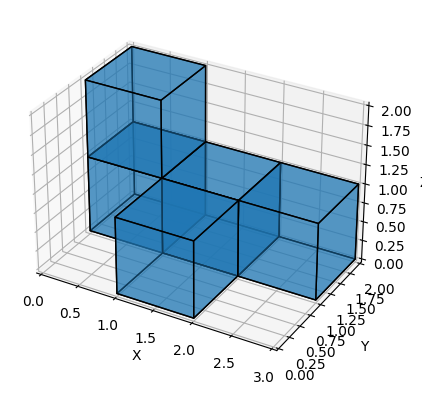

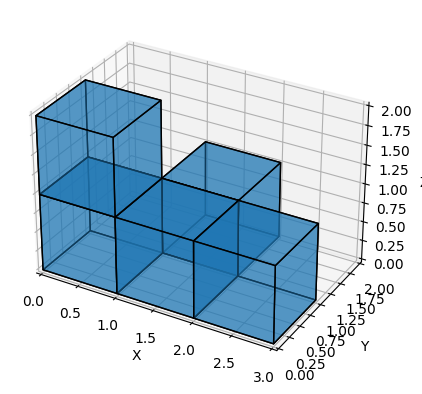

Pair:


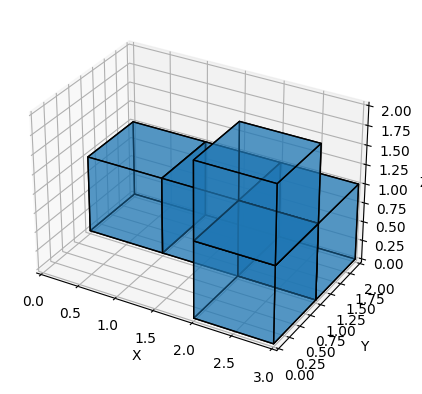

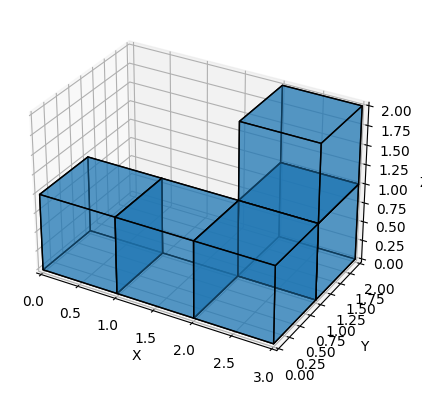

Pair:


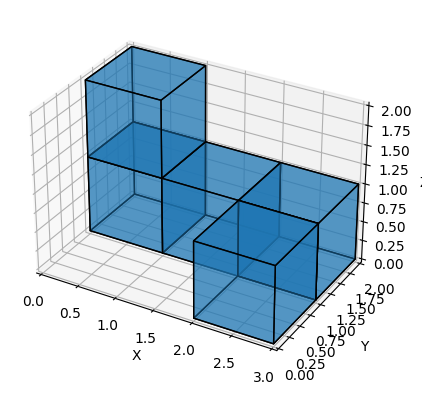

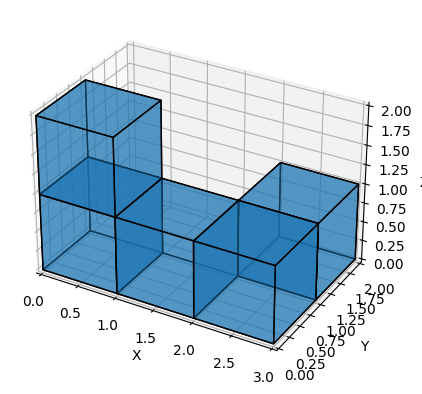

Pair:


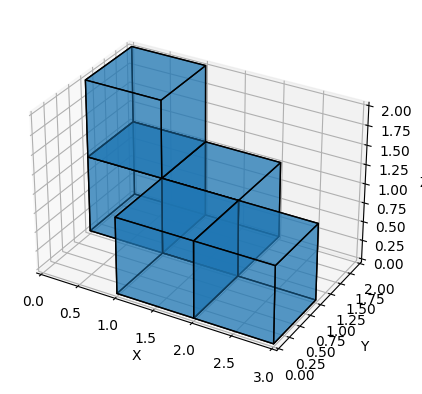

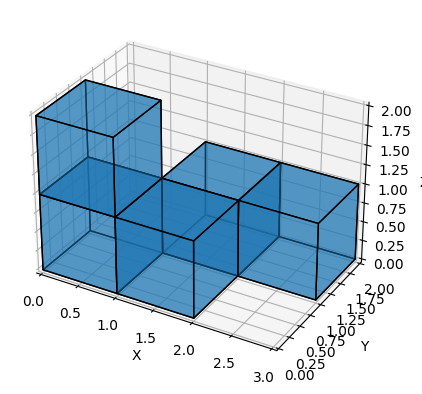

Pair:


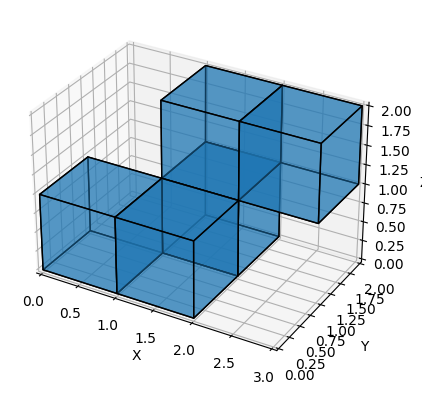

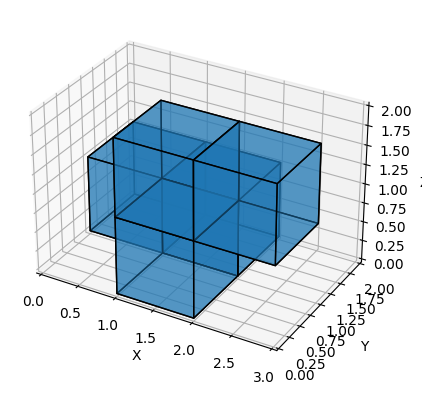

In [10]:
flip_y = np.diag([1, -1, 1])
mirror_pairs = [
    [optimize(pair[0]), recenter(optimize(pair[0]) @ flip_y)]
    for pair in original_mirror_pairs
]
for pair in mirror_pairs:
    print("Pair:")
    draw([(None, pair[0])])
    draw([(None, pair[1])])

## SAT solving to figure out how lucky/unlucky Drake got

In [11]:
def find_valid_piece_orientations(piece: np.ndarray):
    rotations = [recenter(piece @ r) for r in SO3]
    spots = []
    for x_offset in range(4):
        for y_offset in range(4):
            for z_offset in range(2):
                for rot in rotations:
                    new = rot + np.array([x_offset, y_offset, z_offset])
                    if (new.max(axis=0) < np.array([4, 4, 2])).all():
                        spots.append(new)
    # Deduplicate if any are redundant.
    already_seen = set()
    result = []
    for spot in spots:
        key = tuple(sorted(map(tuple, spot)))
        if key in already_seen:
            continue
        already_seen.add(key)
        result.append(spot)
    return result

In [12]:
small_piece = np.array([[0, 0, 0], [1, 0, 0]])
assert len(find_valid_piece_orientations(small_piece)) == 64
for pair in mirror_pairs:
    counts = [len(find_valid_piece_orientations(piece)) for piece in pair]
    assert counts[0] == counts[1]

In [13]:
def canonicalize(spot):
    return tuple(sorted(map(tuple, spot)))

def make_sat_instance(decisions):
    assert len(decisions) == len(mirror_pairs)
    canon_spot_to_var = {}
    var_to_color = {}
    clauses = []
    selected_pieces = [pair[which] for which, pair in zip(decisions, mirror_pairs)]
    selected_pieces += [small_piece]
    # Demand that we place each piece at least once.
    for color, selected in enumerate(selected_pieces):
        clause = []
        for spot in find_valid_piece_orientations(selected):
            new_var = len(canon_spot_to_var) + 1
            canon_spot = canonicalize(spot)
            canon_spot_to_var[canon_spot] = new_var
            var_to_color[new_var] = color, canon_spot
            clause.append(new_var)
        clauses.append(clause)
    # Prevent collisions between different pieces.
    for i, piece_a in enumerate(selected_pieces):
        for spot_a in find_valid_piece_orientations(piece_a):
            spot_a = canonicalize(spot_a)
            for piece_b in selected_pieces[:i]:
                for spot_b in find_valid_piece_orientations(piece_b):
                    spot_b = canonicalize(spot_b)
                    if set(spot_a) & set(spot_b):
                        var_a = canon_spot_to_var[spot_a]
                        var_b = canon_spot_to_var[spot_b]
                        clauses.append([-var_a, -var_b])
    return clauses, var_to_color

In [14]:
def solve_and_show(instance, var_to_color):
    with Solver(name='Glucose3') as solver:
        solver.append_formula(instance)
        satisfiable = solver.solve()
        if not satisfiable:
            print("UNSAT!")
            return False
        solution = solver.get_model()
        solution = [x for x in solution if x > 0]
    colors = {
        0: "red",
        1: "green",
        2: "blue",
        3: "purple",
        4: "yellow",
        5: "cyan",
        6: "white",
    }
    draw([
        (
            colors[var_to_color[var][0]],
            np.array(var_to_color[var][1]),
        ) for var in solution
    ])
    return True

Trying: [0, 0, 0, 0, 0, 0]


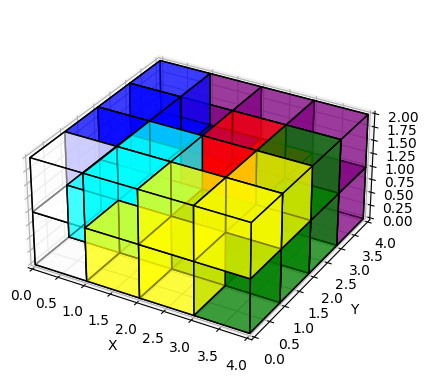

Trying: [0, 0, 0, 0, 0, 1]


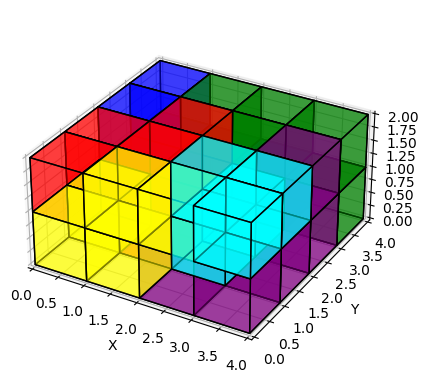

Trying: [0, 0, 0, 0, 1, 0]
UNSAT!
Trying: [0, 0, 0, 0, 1, 1]


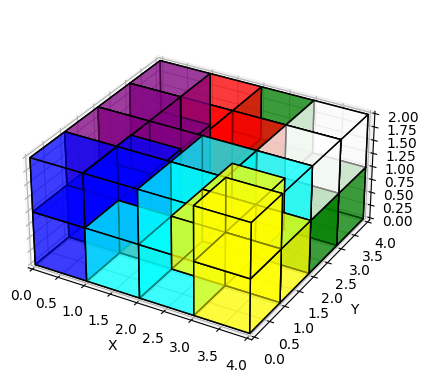

Trying: [0, 0, 0, 1, 0, 0]


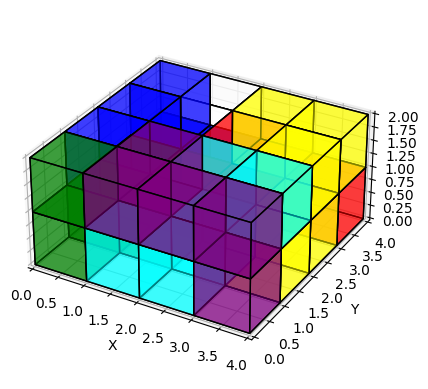

Trying: [0, 0, 0, 1, 0, 1]
UNSAT!
Trying: [0, 0, 0, 1, 1, 0]


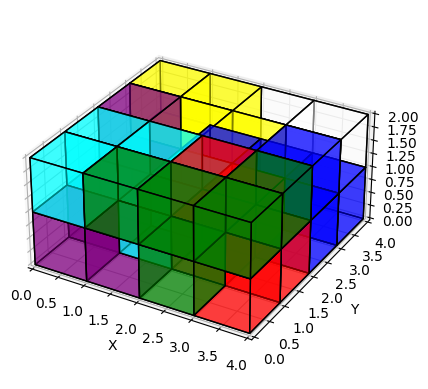

Trying: [0, 0, 0, 1, 1, 1]


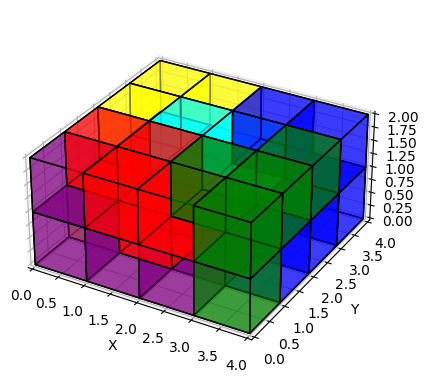

Trying: [0, 0, 1, 0, 0, 0]


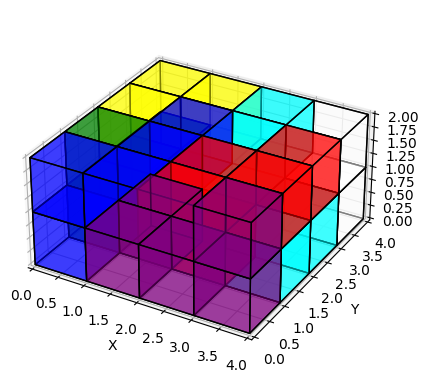

Trying: [0, 0, 1, 0, 0, 1]
UNSAT!
Trying: [0, 0, 1, 0, 1, 0]


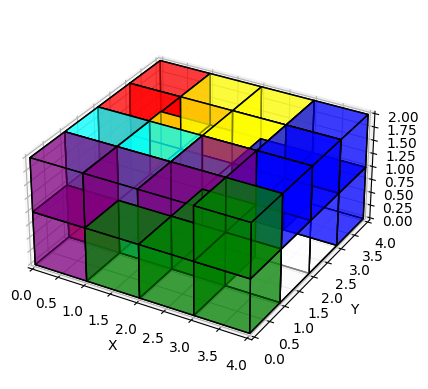

Trying: [0, 0, 1, 0, 1, 1]
UNSAT!
Trying: [0, 0, 1, 1, 0, 0]


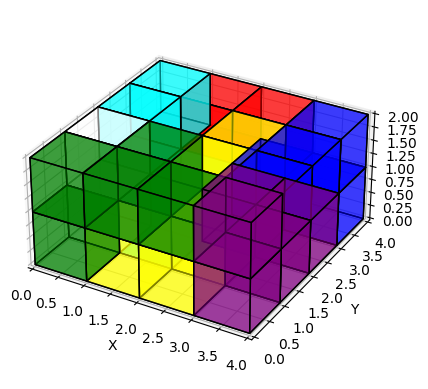

Trying: [0, 0, 1, 1, 0, 1]


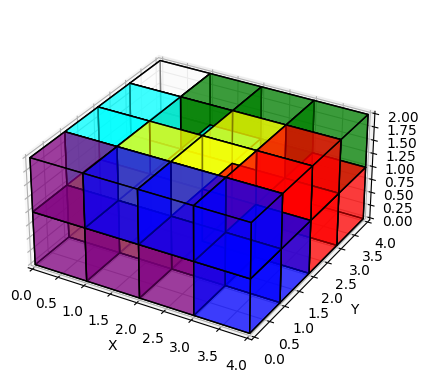

Trying: [0, 0, 1, 1, 1, 0]


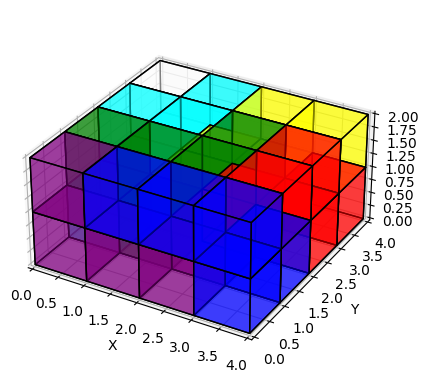

Trying: [0, 0, 1, 1, 1, 1]
UNSAT!
Trying: [0, 1, 0, 0, 0, 0]
UNSAT!
Trying: [0, 1, 0, 0, 0, 1]


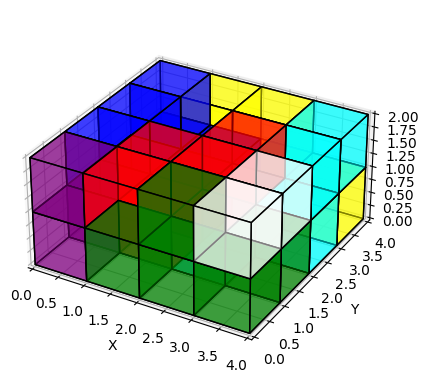

Trying: [0, 1, 0, 0, 1, 0]


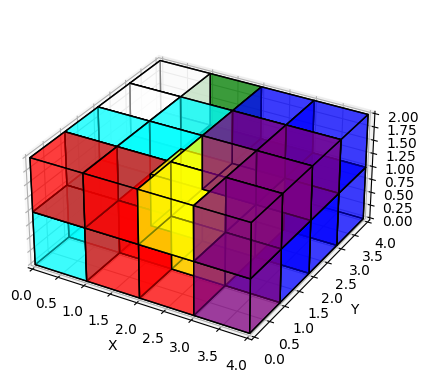

Trying: [0, 1, 0, 0, 1, 1]


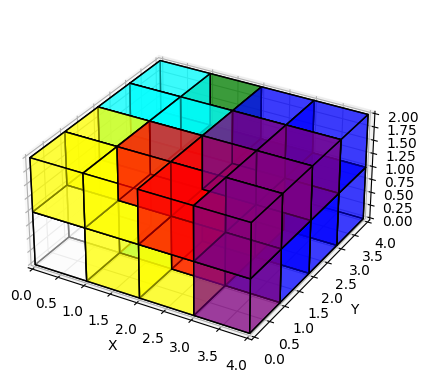

Trying: [0, 1, 0, 1, 0, 0]


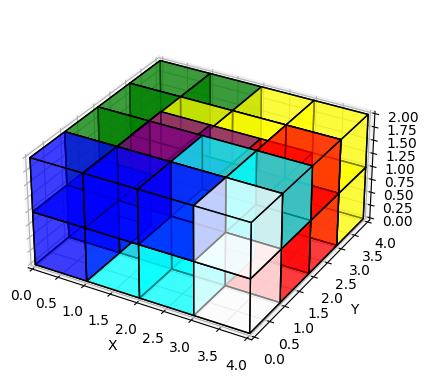

Trying: [0, 1, 0, 1, 0, 1]
UNSAT!
Trying: [0, 1, 0, 1, 1, 0]


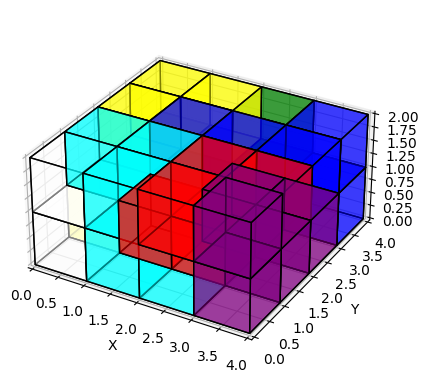

Trying: [0, 1, 0, 1, 1, 1]
UNSAT!
Trying: [0, 1, 1, 0, 0, 0]
UNSAT!
Trying: [0, 1, 1, 0, 0, 1]


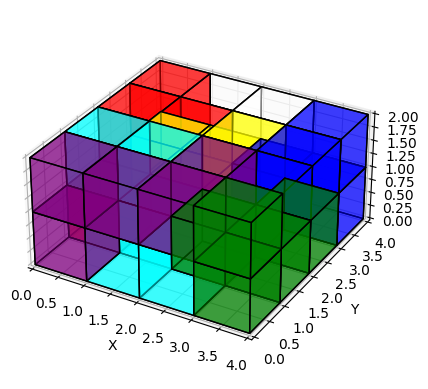

Trying: [0, 1, 1, 0, 1, 0]


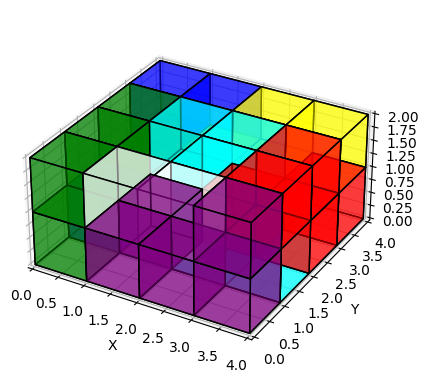

Trying: [0, 1, 1, 0, 1, 1]


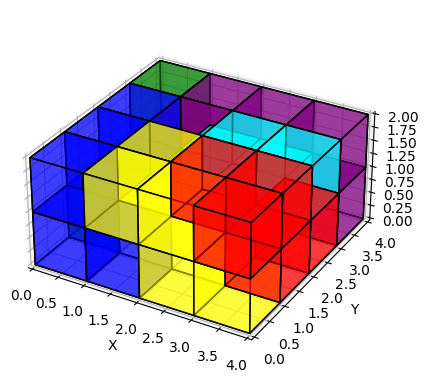

Trying: [0, 1, 1, 1, 0, 0]


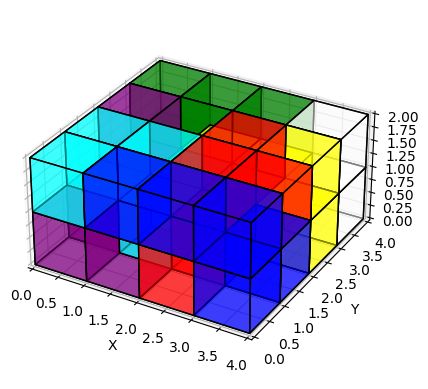

Trying: [0, 1, 1, 1, 0, 1]


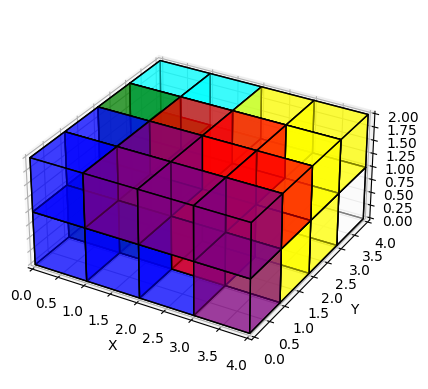

Trying: [0, 1, 1, 1, 1, 0]


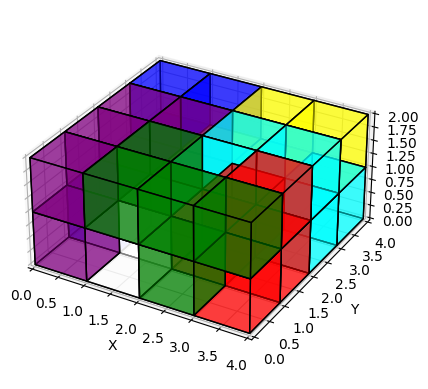

Trying: [0, 1, 1, 1, 1, 1]


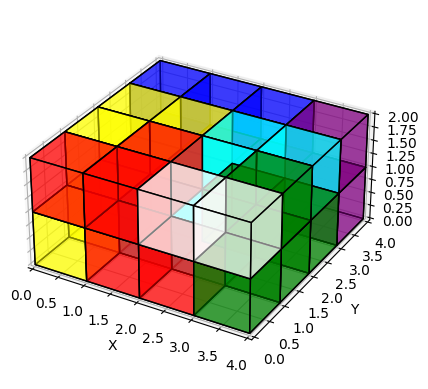

Success count: 23
CPU times: user 3min 1s, sys: 12.1 s, total: 3min 13s
Wall time: 2min 51s


In [15]:
%%time
successes = 0
for suffix in itertools.product([0, 1], repeat=5):
    decisions = [0] + list(suffix)
    print("Trying:", decisions)
    instance, var_to_color = make_sat_instance(decisions)
    successes += solve_and_show(instance, var_to_color)
print("Success count:", successes)